# Atmospheric composition distribution by CAMS and TROPOMI

### Main goal:
* Compare TROPOMI and CAMS datasets for NO2 and CO

### TODO
* Add apriori data to calculate component column for ozone

## Imports and supporting functions

In [1]:
import os
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson

In [2]:
%run functions_general.ipynb
%run functions_cams.ipynb
%run functions_tropomi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

### Notes:

* eccodes must be installed to be able to read grib files (Linux)
    * Reference: https://gist.github.com/MHBalsmeier/a01ad4e07ecf467c90fad2ac7719844a

* cartopy needs the following:
    * sudo apt-get install libproj-dev proj-data proj-bin 
    * sudo apt-get install libgeos-dev 
    * sudo pip install cython

## 1. Define datasets

In [4]:
model = 'cams'
sensor = 'tropomi'
component_nom = 'NO2'

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(component_nom)

# Folders generation
generate_folders(model, sensor, component_nom)

  Nomenclature  Weight         Component TROPOMI_product  \
0          NO2  46.005  nitrogen_dioxide      L2__NO2___   
1           CO  28.010   carbon_monoxide      L2__CO____   
2           O3  48.000             ozone      L2__O3____   
3          SO2  64.066   sulphur_dioxide      L2__SO2___   
4          CH4  16.040           methane      L2__CH4___   

                        TROPOMI_column  
0  nitrogendioxide_tropospheric_column  
1          carbonmonoxide_total_column  
2          ozone_total_vertical_column  
3  sulfurdioxide_total_vertical_column  
4          methane_tropospheric_column  


In [5]:
# Define latitudes and longitudes

lat_min = 48.5
lat_max = 51.1
lon_min = 12
lon_max = 18.9
"""
# Define latitudes and longitudes
lat_min = 47
lat_max = 50
lon_min = 1
lon_max = 4
"""
# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

In [6]:
# Define period
period = ('2021-07-21T00:00:00Z', '2021-07-21T23:00:00Z')
start_date = period[0].split('T')[0]
end_date = period[1].split('T')[0]

## 2. Sensor data

### Collect and read data as xarray

In [7]:
# Used for testing (Change period above)
file_name = 'd762cc7a-f037-4fb8-bc04-cac8e7f39f5b'
product_name = 'S5P_NRTI_L2__NO2____20210621T124026_20210621T124526_19112_01_010400_20210621T132518.nc'

# Download file
input_type = 'Query'
processing_mode = 'Near real time' # Offline, Near real time, Reprocessing
file_name, product_name = TROPOMI_download(input_type, bbox, period, product_type, processing_mode)

# Read file
sensor_ds = TROPOMI_read(product_name, component_nom)
sensor_ds

You can see all the results at https://s5phub.copernicus.eu/dhus/.
RESULTS
Number 0: S5P_NRTI_L2__NO2____20210721T113737_20210721T114237_19537_02_020200_20210721T124127
SELECTED
File name: 42ceb065-e6e8-4783-9e6b-4a01d266f54d
Product name: S5P_NRTI_L2__NO2____20210721T113737_20210721T114237_19537_02_020200_20210721T124127.nc
The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 372, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...

### Calculate level pressures

In [8]:
sensor_ds = TROPOMI_pressure(sensor_ds, product_name, component_nom)
sensor_ds

The layer pressures will be calculated.


<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 372, time: 1, vertices: 2)
Coordinates:
  * ground_pixel                                          (ground_pixel) float64 ...
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/13)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, vertices, time, scanline, ground_pixel) float32 ...

### Calculate column kernels

In [9]:
sensor_ds = TROPOMI_kernel_column(sensor_ds)
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 372, time: 1, vertices: 2)
Coordinates:
  * ground_pixel                                          (ground_pixel) float64 ...
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/14)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, vertices, time, scanline, ground_pixel) float32 ...
    kernel_column                                         (layer, time, scanline, ground_pixel) float32 ...

### Subset data

In [10]:
sensor_ds = TROPOMI_subset(sensor_ds, product_name, bbox)
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 144, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 76, time: 1, vertices: 2)
Coordinates:
  * ground_pixel                                          (ground_pixel) float64 ...
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/14)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, vertices, time, scanline, ground_pixel) float32 ...
    kernel_column                                         (layer, time, scanline, ground_pixel) float32 ...

In [11]:
sensor_coords_df = TROPOMI_subset_coords(sensor_ds)
sensor_coords_df

ground_pixel  scanline   latitude  longitude
0             127.0     163.0  47.145008  12.773775
1             127.0     164.0  47.192677  12.749171
2             127.0     165.0  47.240311  12.724477
3             127.0     166.0  47.287945  12.699731
4             127.0     167.0  47.335583  12.674969
...             ...       ...        ...        ...
10939         270.0     234.0  52.126972  18.402065
10940         270.0     235.0  52.175411  18.381380
10941         270.0     236.0  52.223846  18.360636
10942         270.0     237.0  52.272293  18.339811
10943         270.0     238.0  52.320763  18.319046

[10944 rows x 4 columns]

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [12]:
sensor_ds = TROPOMI_convert_units(sensor_ds, sensor_column)
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 144, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 76, time: 1, vertices: 2)
Coordinates:
  * ground_pixel                                          (ground_pixel) float64 ...
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables: (12/14)
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float64 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    ...                                                    ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    pressure                                              (layer, vertices, time, scanline, ground_pixel) float32 ...
    kernel_column                                         (layer, time, scanline, ground_pixel) float32 ...

## 3. Model data

### Collect and read data as xarray

In [13]:
CAMS_download(start_date, end_date, component, component_nom)
model_ds = CAMS_read(start_date, end_date, component, component_nom)
model_ds

The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 451, longitude: 900, step: 4)
Coordinates:
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-08-11T06:32 GRIB to CDM+CF via cfgrib-0.9.9...

In [14]:
model_ds = CAMS_subset(model_ds, bbox)
model_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 8, longitude: 18, step: 4)
Coordinates:
    time        datetime64[ns] 2021-07-21
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (step) datetime64[ns] 2021-07-21 ... 2021-07-21T18:00:00
Data variables:
    component   (step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-08-11T06:32 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [15]:
model_levels = CAMS_137_levels()
model_levels

a [Pa]         b   ph [hPa]   pf [hPa]  Geopotential Altitude [m]  \
hybrid                                                                         
1        2.000365  0.000000     0.0200     0.0100                   79301.79   
2        3.102241  0.000000     0.0310     0.0255                   73721.58   
3        4.666084  0.000000     0.0467     0.0388                   71115.75   
4        6.827977  0.000000     0.0683     0.0575                   68618.43   
5        9.746966  0.000000     0.0975     0.0829                   66210.99   
...           ...       ...        ...        ...                        ...   
133     62.781250  0.988500  1002.2250  1000.5165                     106.54   
134     22.835938  0.991984  1005.3562  1003.7906                      79.04   
135      3.757813  0.995003  1008.2239  1006.7900                      53.92   
136      0.000000  0.997630  1010.8487  1009.5363                      30.96   
137      0.000000  1.000000  1013.2500  1012.0494                      10.00   

       Geometric Altitude [m] Temperature [K]  Density [kg/m^3]    ph [Pa]  \
hybrid                                                                       
1                    80301.65          198.05          0.000018       2.00   
2                    74584.91          209.21          0.000042       3.10   
3                    71918.79          214.42          0.000063       4.67   
4                    69365.77          221.32          0.000090       6.83   
5                    66906.53          228.06          0.000127       9.75   
...                       ...             ...               ...        ...   
133                    106.54          287.46          1.212498  100222.50   
134                     79.04          287.64          1.215710  100535.62   
135                     53.92          287.80          1.218650  100822.39   
136                     30.96          287.95          1.221341  101084.87   
137                     10.00          288.09          1.223803  101325.00   

        ph-diff [Pa]  Depth [m]  
hybrid                           
1               2.00    5580.21  
2               1.10    2605.83  
3               1.57    2497.32  
4               2.16    2407.44  
5               2.92    2320.96  
...              ...        ...  
133           341.69      27.50  
134           313.12      25.12  
135           286.77      22.96  
136           262.48      20.96  
137           240.13      10.00  

[137 rows x 11 columns]

### Convert CAMS data units (kg/kg to molecules/cm<sup>2</sup>)

In [16]:
conversion_method = 'Simple'
model_ds = CAMS_kg_kg_to_kg_m2(model_ds, model_levels, conversion_method)
model_ds = CAMS_kg_m2_to_molecules_cm2(model_ds, component_mol_weight)

## 4. Apply averaging kernels

In [17]:
match_df = sensor_ds.to_dataframe()

if 'kernel_column' in list(sensor_ds.keys()):
    
    print('This dataset contains data to apply the column averaging kernels.')
    kernels_method = 'Interpolation'
    match_df = TROPOMI_apply_avg_kernels(kernels_method, match_df)
    
else:
    
    print('This dataset does not contain data to apply the averaging kernels.')
    print('The partial columns will be sumed up.')
    print('The sum will be matched to the sensor data by nearest neighbours.')

    model_ds = model_ds.component.sum(dim = 'hybrid', skipna = False)
    model_times = model_ds.valid_time.data

    match_df = match_df.reset_index(level = ['layer'])
    match_df = match_df.droplevel(['corner']).drop_duplicates()

    match_df['step_index'] = match_df.apply(lambda row: nearest_neighbour(model_times, row['delta_time']), axis = 1)
    match_df['model_time'] = match_df.apply(lambda row: model_ds.valid_time[row['step_index']].values, axis = 1)
    match_df['model_column'] = match_df.apply(lambda row: model_ds.sel(latitude = row['latitude'], 
                                                                       longitude = row['longitude'],
                                                                       method = 'nearest').isel(step = int(row['step_index'])).values, 
                                                                       axis = 1)

match_df

This dataset contains data to apply the column averaging kernels.
The application of averaging kernels will start now.


pressure  layer              delta_time  \
time       scanline ground_pixel                                                
2021-07-21 163.0    127.0         76352.250000    0.0 2021-07-21 11:39:49.010   
                    127.0         75396.070312    1.0 2021-07-21 11:39:49.010   
                    127.0         73775.031250    2.0 2021-07-21 11:39:49.010   
                    127.0         71428.296875    3.0 2021-07-21 11:39:49.010   
                    127.0         68106.742188    4.0 2021-07-21 11:39:49.010   
...                                        ...    ...                     ...   
           238.0    270.0           625.780151   29.0 2021-07-21 11:40:52.009   
                    270.0           309.465515   30.0 2021-07-21 11:40:52.009   
                    270.0           130.429565   31.0 2021-07-21 11:40:52.009   
                    270.0            44.064754   32.0 2021-07-21 11:40:52.009   
                    270.0             9.304465   33.0 2021-07-21 11:40:52.009   

                                   latitude  longitude  qa_value  \
time       scanline ground_pixel                                   
2021-07-21 163.0    127.0         47.145008  12.773775      1.00   
                    127.0         47.145008  12.773775      1.00   
                    127.0         47.145008  12.773775      1.00   
                    127.0         47.145008  12.773775      1.00   
                    127.0         47.145008  12.773775      1.00   
...                                     ...        ...       ...   
           238.0    270.0         52.320763  18.319046      0.74   
                    270.0         52.320763  18.319046      0.74   
                    270.0         52.320763  18.319046      0.74   
                    270.0         52.320763  18.319046      0.74   
                    270.0         52.320763  18.319046      0.74   

                                  nitrogendioxide_tropospheric_column  \
time       scanline ground_pixel                                        
2021-07-21 163.0    127.0                                9.389191e+13   
                    127.0                                9.389191e+13   
                    127.0                                9.389191e+13   
                    127.0                                9.389191e+13   
                    127.0                                9.389191e+13   
...                                                               ...   
           238.0    270.0                                9.508593e+14   
                    270.0                                9.508593e+14   
                    270.0                                9.508593e+14   
                    270.0                                9.508593e+14   
                    270.0                                9.508593e+14   

                                  nitrogendioxide_tropospheric_column_precision  \
time       scanline ground_pixel                                                  
2021-07-21 163.0    127.0                                              0.000009   
                    127.0                                              0.000009   
                    127.0                                              0.000009   
                    127.0                                              0.000009   
                    127.0                                              0.000009   
...                                                                         ...   
           238.0    270.0                                              0.000011   
                    270.0                                              0.000011   
                    270.0                                              0.000011   
                    270.0                                              0.000011   
                    270.0                                              0.000011   

                                  nitrogendioxide_tropospheric_column

In [18]:
match_df

pressure  layer              delta_time  \
time       scanline ground_pixel                                                
2021-07-21 163.0    127.0         76352.250000    0.0 2021-07-21 11:39:49.010   
                    127.0         75396.070312    1.0 2021-07-21 11:39:49.010   
                    127.0         73775.031250    2.0 2021-07-21 11:39:49.010   
                    127.0         71428.296875    3.0 2021-07-21 11:39:49.010   
                    127.0         68106.742188    4.0 2021-07-21 11:39:49.010   
...                                        ...    ...                     ...   
           238.0    270.0           625.780151   29.0 2021-07-21 11:40:52.009   
                    270.0           309.465515   30.0 2021-07-21 11:40:52.009   
                    270.0           130.429565   31.0 2021-07-21 11:40:52.009   
                    270.0            44.064754   32.0 2021-07-21 11:40:52.009   
                    270.0             9.304465   33.0 2021-07-21 11:40:52.009   

                                   latitude  longitude  qa_value  \
time       scanline ground_pixel                                   
2021-07-21 163.0    127.0         47.145008  12.773775      1.00   
                    127.0         47.145008  12.773775      1.00   
                    127.0         47.145008  12.773775      1.00   
                    127.0         47.145008  12.773775      1.00   
                    127.0         47.145008  12.773775      1.00   
...                                     ...        ...       ...   
           238.0    270.0         52.320763  18.319046      0.74   
                    270.0         52.320763  18.319046      0.74   
                    270.0         52.320763  18.319046      0.74   
                    270.0         52.320763  18.319046      0.74   
                    270.0         52.320763  18.319046      0.74   

                                  nitrogendioxide_tropospheric_column  \
time       scanline ground_pixel                                        
2021-07-21 163.0    127.0                                9.389191e+13   
                    127.0                                9.389191e+13   
                    127.0                                9.389191e+13   
                    127.0                                9.389191e+13   
                    127.0                                9.389191e+13   
...                                                               ...   
           238.0    270.0                                9.508593e+14   
                    270.0                                9.508593e+14   
                    270.0                                9.508593e+14   
                    270.0                                9.508593e+14   
                    270.0                                9.508593e+14   

                                  nitrogendioxide_tropospheric_column_precision  \
time       scanline ground_pixel                                                  
2021-07-21 163.0    127.0                                              0.000009   
                    127.0                                              0.000009   
                    127.0                                              0.000009   
                    127.0                                              0.000009   
                    127.0                                              0.000009   
...                                                                         ...   
           238.0    270.0                                              0.000011   
                    270.0                                              0.000011   
                    270.0                                              0.000011   
                    270.0                                              0.000011   
                    270.0                                              0.000011   

                                  nitrogendioxide_tropospheric_column

In [19]:
match_df = match_df.set_index('layer', append = True)

In [20]:
match_ds = match_df.to_xarray()

# Read latitudes and longitudes from data array
latitude = match_ds.latitude.mean(dim = 'layer')
longitude = match_ds.longitude.mean(dim = 'layer')

# Get sum of CAMS data of each layer to get column data
if 'averaging_kernel' in list(sensor_ds.keys()):
    model_final_ds = match_ds.model_column.sum(dim = 'layer', skipna = False).astype(float)

else:
    model_final_ds = match_ds.model_column.mean(dim = 'layer', skipna = False).astype(float)

model_final_ds = model_final_ds.assign_coords(latitude = latitude, longitude = longitude)

# Get mean of TROPOMI data of each layer (it must be equal)
sensor_final_ds = match_ds[sensor_column].mean(dim = 'layer', skipna = False).astype(float)
sensor_final_ds = sensor_final_ds.assign_coords(latitude = latitude, longitude = longitude)

## 5. Merge data

In [21]:
merged_ds = xr.merge([model_final_ds, sensor_final_ds])
merged_df = merged_ds.to_dataframe()
merged_df['Difference'] = merged_df[sensor_column] - merged_df['model_column']
merged_df

latitude  longitude  model_column  \
ground_pixel scanline time                                             
127.0        163.0    2021-07-21  47.145008  12.773775  2.772169e+14   
             164.0    2021-07-21  47.192677  12.749171  2.773779e+14   
             165.0    2021-07-21  47.240311  12.724477  2.681351e+14   
             166.0    2021-07-21  47.287945  12.699731  2.836338e+14   
             167.0    2021-07-21  47.335583  12.674969  2.676252e+14   
...                                     ...        ...           ...   
270.0        234.0    2021-07-21  52.126972  18.402065  3.156003e+14   
             235.0    2021-07-21  52.175411  18.381380  3.249655e+14   
             236.0    2021-07-21  52.223846  18.360636  2.517260e+14   
             237.0    2021-07-21  52.272293  18.339811  2.394115e+14   
             238.0    2021-07-21  52.320763  18.319046  2.353710e+14   

                                  nitrogendioxide_tropospheric_column  \
ground_pixel scanline time                                              
127.0        163.0    2021-07-21                         9.389191e+13   
             164.0    2021-07-21                         1.147599e+15   
             165.0    2021-07-21                         1.635275e+15   
             166.0    2021-07-21                         4.603524e+14   
             167.0    2021-07-21                         1.082807e+15   
...                                                               ...   
270.0        234.0    2021-07-21                         2.028691e+15   
             235.0    2021-07-21                        -2.693204e+14   
             236.0    2021-07-21                         8.426893e+14   
             237.0    2021-07-21                         2.368477e+15   
             238.0    2021-07-21                         9.508593e+14   

                                    Difference  
ground_pixel scanline time                      
127.0        163.0    2021-07-21 -1.833250e+14  
             164.0    2021-07-21  8.702210e+14  
             165.0    2021-07-21  1.367140e+15  
             166.0    2021-07-21  1.767186e+14  
             167.0    2021-07-21  8.151815e+14  
...                                        ...  
270.0        234.0    2021-07-21  1.713091e+15  
             235.0    2021-07-21 -5.942859e+14  
             236.0    2021-07-21  5.909633e+14  
             237.0    2021-07-21  2.129065e+15  
             238.0    2021-07-21  7.154883e+14  

[10944 rows x 5 columns]

## 6. Visualize data

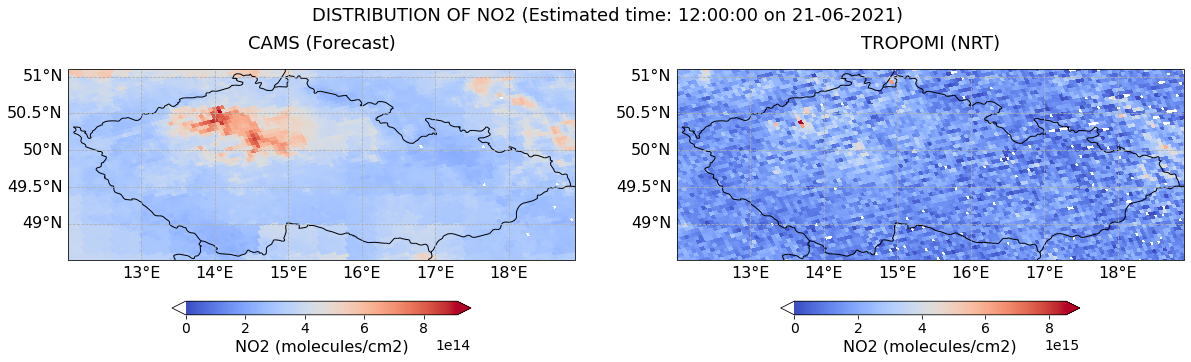

In [22]:
units = component_nom + ' (molecules/cm2)'
projection = ccrs.PlateCarree()

for step in match_df['step_index'].unique():
    
    fig, axs = plt.subplots(1, 2, figsize = (20, 5), subplot_kw = {'projection': projection})

    t = model_ds.isel(step = step).time

    """
    # Define vmin
    if (np.nanmin(sensor_final_ds.sel(time = t)) < np.nanmin(model_final_ds.sel(time = t))) and np.nanmin(sensor_final_ds.sel(time = t)) >= 0:
        vmin = np.nanmin(sensor_final_ds.sel(time = t))
    else:
        vmin = np.nanmin(model_final_ds.sel(time = t))
    
    # Define vmax
    if np.nanmax(sensor_final_ds.sel(time = t)) < np.nanmax(model_final_ds.sel(time = t)):
        vmax = np.nanmax(model_final_ds.sel(time = t))
    else:
        vmax = np.nanmax(sensor_final_ds.sel(time = t))
    """ 

    # First plot - CAMS 
    array = model_final_ds.sel(time = t)
    long_name = model.upper() + ' (Forecast)'
    visualize_pcolormesh(
                        fig = fig, axs = axs[0],
                        data_array = array.fillna(-999),
                        longitude = array.longitude,
                        latitude = array.latitude,
                        projection = ccrs.PlateCarree(),
                        color_scale = 'coolwarm',
                        long_name = long_name,
                        units = units,
                        vmin = 0, 
                        vmax = np.nanmax(array), 
                        set_global = False,
                        lonmin = bbox[0][0],
                        lonmax = bbox[1][0],
                        latmin = bbox[0][1],
                        latmax = bbox[1][1]
                        )

    # Second plot - TROPOMI
    array = sensor_final_ds.sel(time = t)
    long_name = sensor.upper() + ' (NRT)'
    visualize_pcolormesh(
                        fig = fig, axs = axs[1],
                        data_array = array.fillna(-999),
                        longitude = array.longitude,
                        latitude = array.latitude,
                        projection = ccrs.PlateCarree(),
                        color_scale = 'coolwarm',
                        long_name = long_name,
                        units = units,
                        vmin = 0,  
                        vmax = np.nanmax(array), 
                        set_global = False,
                        lonmin = bbox[0][0],
                        lonmax = bbox[1][0],
                        latmin = bbox[0][1],
                        latmax = bbox[1][1]
                        )

    fig.suptitle(f'DISTRIBUTION OF {component_nom} (Estimated time: 12:00:00 on 21-06-2021)',
                  fontsize = 18)
    plt.show()

## 7. Compare CAMS original and calculated total columns

In [23]:
CAMS_tc_download(start_date, end_date, component, component_nom)
model_total_ds = CAMS_tc_read(start_date, end_date, component, component_nom)
model_total_ds = CAMS_subset(model_total_ds, bbox)
component_nom_total = 'tc' + component_nom.lower()

The file exists, it will not be downloaded again.


In [24]:
# From kg/m2 to molecules/cm2
model_total_ds = CAMS_kg_m2_to_molecules_cm2(model_total_ds, component_mol_weight)
model_total_ds

<xarray.Dataset>
Dimensions:     (latitude: 8, longitude: 18, step: 4)
Coordinates:
    number      int64 ...
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
    surface     float64 ...
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (step) datetime64[ns] ...
Data variables:
    tcno2       (step, latitude, longitude) float32 6.235e+15 ... 5.388e+15
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-08-11T08:17 GRIB to CDM+CF via cfgrib-0.9.9...

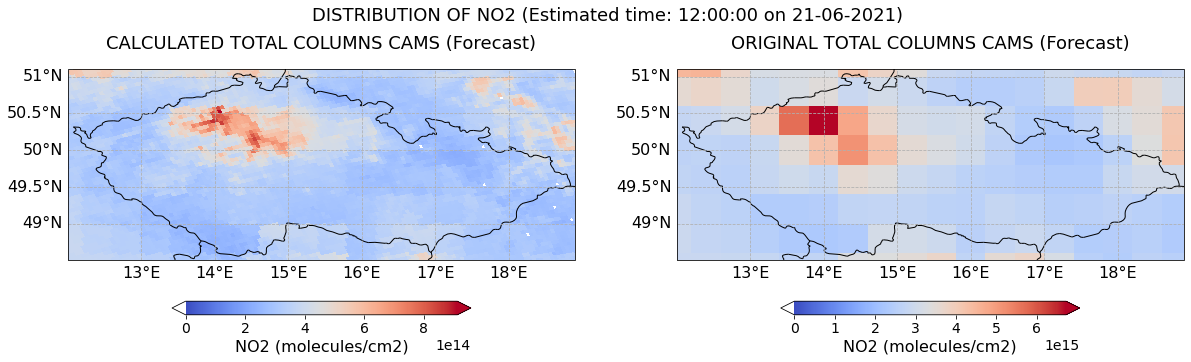

In [26]:
units = component_nom + ' (molecules/cm2)'
projection = ccrs.PlateCarree()

for step in match_df['step_index'].unique():

    fig, axs = plt.subplots(1, 2, figsize = (20, 5), subplot_kw = {'projection': projection})

    t = model_ds.isel(step = step).time

    # First plot - CAMS
    array = model_final_ds.sel(time = t)
    long_name = 'CALCULATED TOTAL COLUMNS ' + model.upper() + ' (Forecast)'
    visualize_pcolormesh(
                        fig = fig, axs = axs[0],
                        data_array = array.fillna(-999),
                        longitude = array.longitude,
                        latitude = array.latitude,
                        projection = ccrs.PlateCarree(),
                        color_scale = 'coolwarm',
                        long_name = long_name,
                        units = units,
                        vmin = 0, 
                        vmax = np.nanmax(array), 
                        set_global = False,
                        lonmin = bbox[0][0],
                        lonmax = bbox[1][0],
                        latmin = bbox[0][1],
                        latmax = bbox[1][1]
                        )

    # Second plot - TROPOMI
    array = model_total_ds[component_nom_total].isel(step = step)
    long_name = 'ORIGINAL TOTAL COLUMNS ' + model.upper() + ' (Forecast)'
    visualize_pcolormesh(
                        fig = fig, axs = axs[1],
                        data_array = array.fillna(-999),
                        longitude = array.longitude,
                        latitude = array.latitude,
                        projection = ccrs.PlateCarree(),
                        color_scale = 'coolwarm',
                        long_name = long_name,
                        units = units,
                        vmin = 0,
                        vmax = np.nanmax(array), 
                        set_global = False,
                        lonmin = bbox[0][0],
                        lonmax = bbox[1][0],
                        latmin = bbox[0][1],
                        latmax = bbox[1][1]
                        )

    fig.suptitle(f'DISTRIBUTION OF {component_nom} (Estimated time: 12:00:00 on 21-06-2021)',
                  fontsize = 18)
    plt.show()


## References
### Data sources
* CAMS global atmospheric composition forecasts (https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview)
* TROPOMI (https://s5phub.copernicus.eu/dhus)

### Important documentation
* TROPOMI user manual (https://sentinels.copernicus.eu/documents/247904/3119978/Sentinel-5P-Level-2-Input-Output-Data-Definition)
* TROPOMI NO2 product manual (http://www.tropomi.eu/sites/default/files/files/S5P-KNMI-L2-0021-MA-Product_User_Manual_for_the_Sentinel_5_precursor_Nitrogen_dioxide-0.8.1_20151207_signed.pdf)
* TROPOMI CO product manual (http://www.tropomi.eu/sites/default/files/files/Sentinel-5P-Level-2-Product-User-Manual-Carbon-Monoxide_v1.00.02_20180613.pdf)
* SENTINEL API documentation (https://readthedocs.org/projects/sentinelsat/downloads/pdf/stable/)
* Xarray API reference (http://xarray.pydata.org/en/stable/api.html)

### External functions
* Interpolation (http://christopherbull.com.au/python/scipy-interpolate-griddata/)
* Visualization function (https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/functions.ipynb)
* Mask NaN values (https://matplotlib.org/2.0.2/examples/pylab_examples/image_masked.html)
* Convert units (https://confluence.ecmwf.int/pages/viewpage.action?pageId=153391710)
* Install eccodes (https://gist.github.com/MHBalsmeier/a01ad4e07ecf467c90fad2ac7719844a)